## Análisis del Proyecto de Precios de Laptops

**Objetivo:** Predicción del precio de las laptops.

**Contexto Comercial:** El mercado de las laptops es competitivo y dinámico, con una amplia variedad de modelos, marcas y precios. Los consumidores buscan información para tomar decisiones informadas, mientras que los vendedores buscan optimizar sus precios y ventas.

**Problema Comercial:**

* **Para los consumidores:** Falta de información clara y precisa sobre el valor real de las laptops en relación a sus características.
* **Para los vendedores:** Dificultad para establecer precios competitivos y estrategias de marketing efectivas, sin comprender la relación entre las características de las laptops y su precio.

**Contexto Analítico:**

* **Base de Datos:** Se dispone de un conjunto de datos con información sobre precios de laptops y sus características (marca, RAM, modelo, etc.).
* **Análisis:** Se utilizarán técnicas de Machine Learning para modelar la relación entre las características de las laptops y su precio.

**Análisis del Proyecto:**

**Análisis Exploratorio de Datos (EDA):**

* **Análisis Univariado:**
    * Distribución de los precios y de cada una de las características (marca, RAM, etc.)
    * Identificar valores atípicos (outliers)
* **Análisis Bivariado:**
    * Correlación entre el precio y cada característica.
    * Visualización de las relaciones mediante gráficos de dispersión.
* **Análisis Multivariado:**
    * Identificar variables que contribuyen significativamente al precio de las laptops.
    * Analizar posibles interacciones entre las variables.

**Modelado:**

* **Selección del modelo:** Elegir un modelo de Machine Learning adecuado para la predicción de precios.
* **Entrenamiento del modelo:** Entrenar el modelo seleccionado con los datos preparados.
* **Evaluación del modelo:** Evaluar el rendimiento del modelo utilizando métricas de evaluación apropiadas (MAE, RMSE, R-cuadrado).


*Importando de Librerias*

In [483]:
from rich.console import Console
from rich.markdown import Markdown
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import re
import warnings
# Libreria para estimar regresión
import statsmodels.formula.api as sm
# Libreria para normalizar
from sklearn.preprocessing import StandardScaler

%matplotlib inline

*Extrayendo Datos:*

In [496]:
url = 'https://raw.githubusercontent.com/JosemaTelCa/ProyectoCoder/refs/heads/main/Laptop-Price.csv'
df = pd.read_csv(url, sep = ',')
print('Exploracion Inicial(primeras 5 filas):')
df.head()

Exploracion Inicial(primeras 5 filas):


,Company,Product,TypeName,Inches,ScreenResolution,Ram,OpSys,Cpu Brand,Cpu Model,Cpu Rate,SSD,HDD,Flash Storage,Hybrid,Gpu Brand,Gpu Model,Unnamed: 16,Price_euros
0,HP,250 G6,Notebook,15.6,Full HD 1920x1080,8GB,No OS,Intel,Core i5 7200U,2.5GHz,256,0,0,0,Intel,HD Graphics 620,NaN,575.0
1,Acer,Aspire 3,Notebook,15.6,1366x768,4GB,Windows 10,AMD,A9-Series 9420,3GHz,0,500,0,0,AMD,Radeon R5,NaN,400.0
2,Asus,ZenBook UX430UN,Ultrabook,14.0,Full HD 1920x1080,16GB,Windows 10,Intel,Core i7 8550U,1.8GHz,512,0,0,0,Nvidia,GeForce MX150,NaN,1495.0
3,Acer,Swift 3,Ultrabook,14.0,IPS Panel Full HD 1920x1080,8GB,Windows 10,Intel,Core i5 8250U,1.6GHz,256,0,0,0,Intel,UHD Graphics 620,NaN,770.0
4,HP,250 G6,Notebook,15.6,1366x768,4GB,No OS,Intel,Core i5 7200U,2.5GHz,0,500,0,0,Intel,HD Graphics 620,NaN,393.9


**Información Actualizada del DataFrame:**

In [497]:
print('Tamaño del DataFrame')
print('Cantidad de filas', df.shape[0])
print('Cantidad de columnas', df.shape[1])

Tamaño del DataFrame
Cantidad de filas 1146
Cantidad de columnas 18


In [498]:
print('Tipo de Datos')
print(df.dtypes)

Tipo de Datos
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Ram                  object
OpSys                object
Cpu Brand            object
Cpu Model            object
Cpu Rate             object
SSD                   int64
HDD                   int64
Flash Storage         int64
Hybrid                int64
Gpu Brand            object
Gpu Model            object
Unnamed: 16         float64
Price_euros         float64
dtype: object


*Descripción de las Columnas*
1. **Company**: La marca o fabricante de la laptop (ej. Dell, HP, Apple).
2. **Product**: El nombre o modelo específico de la laptop (ej. Inspiron, MacBook).
3. **TypeName**: Tipo de laptop, como Notebook, Ultrabook, Gaming, etc.
4. **Inches**: Tamaño de la pantalla en pulgadas.
5. **ScreenResolution**: Resolución de la pantalla (ej. 1920x1080, 1366x768).
6. **Ram**: Cantidad de memoria RAM, generalmente en GB.
7. **OpSys**: Sistema operativo instalado (ej. Windows, macOS, Linux).
8. **Cpu Brand**: Marca del procesador (ej. Intel, AMD).
9. **Cpu Model**: Modelo específico del procesador (ej. Core i5-8250U).
10. **Cpu Rate**: Frecuencia del procesador, en GHz.
11. **SSD**: Capacidad de almacenamiento en disco de estado sólido (SSD) en GB.
12. **HDD**: Capacidad de almacenamiento en disco duro (HDD) en GB.
13. **Flash Storage**: Capacidad de almacenamiento en memoria flash, si está presente.
14. **Hybrid**: Espacio de almacenamiento en discos híbridos (combinación de SSD y HDD).
15. **Gpu Brand**: Marca de la tarjeta gráfica (ej. Nvidia, AMD, Intel).
16. **Gpu Model**: Modelo específico de la tarjeta gráfica.
17. **Unnamed: 16**: Columna sin nombre; puede contener datos no categorizados o estar vacía.
18. **Price_euros**: Precio de la laptop en euros.

**Preparación de los Datos:**

* **Limpieza de datos:** Eliminar valores faltantes, valores duplicados y tratar outliers.
* **Transformación de variables:** Codificar variables categóricas (marca, modelo).
* **Escalado de datos:** Establecer una escala común para todas las variables numéricas.

In [499]:
# Función para extraer el valor numérico promedio de resolución
def extract_resolution(resolution):
    # Utiliza expresiones regulares para encontrar los números en la cadena
    numbers = re.findall(r'\d+', resolution)
    # Si encontramos números, convertimos a float y regresamos el promedio
    if numbers:
        return float(numbers[0])  # Puedes cambiarlo si necesitas otro valor
    return None  # Para los casos donde no haya números

# Aplicar la función a la columna 'ScreenResolution'
df['ScreenResolution'] = df['ScreenResolution'].apply(extract_resolution)

# Imprimir el DataFrame resultante
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Ram,OpSys,Cpu Brand,Cpu Model,Cpu Rate,SSD,HDD,Flash Storage,Hybrid,Gpu Brand,Gpu Model,Unnamed: 16,Price_euros
0,HP,250 G6,Notebook,15.6,1920.0,8GB,No OS,Intel,Core i5 7200U,2.5GHz,256,0,0,0,Intel,HD Graphics 620,NaN,575.0
1,Acer,Aspire 3,Notebook,15.6,1366.0,4GB,Windows 10,AMD,A9-Series 9420,3GHz,0,500,0,0,AMD,Radeon R5,NaN,400.0
2,Asus,ZenBook UX430UN,Ultrabook,14.0,1920.0,16GB,Windows 10,Intel,Core i7 8550U,1.8GHz,512,0,0,0,Nvidia,GeForce MX150,NaN,1495.0
3,Acer,Swift 3,Ultrabook,14.0,1920.0,8GB,Windows 10,Intel,Core i5 8250U,1.6GHz,256,0,0,0,Intel,UHD Graphics 620,NaN,770.0
4,HP,250 G6,Notebook,15.6,1366.0,4GB,No OS,Intel,Core i5 7200U,2.5GHz,0,500,0,0,Intel,HD Graphics 620,NaN,393.9



*Las columnas que no contienen valores numericos no aportarán al análisis, por lo que es mejor eliminarlas de DataFrame*


In [500]:
# Eliminar las columnas que no aportan al analisis:
cols_to_drop = [0,1,2,6,7,8,12,13,14,15,16]
df = df.drop(df.columns[cols_to_drop], axis=1)

print('Exploracion Inicial(primeras 5 filas):')
df.head()

Exploracion Inicial(primeras 5 filas):


,Inches,ScreenResolution,Ram,Cpu Rate,SSD,HDD,Price_euros
0,15.6,1920.0,8GB,2.5GHz,256,0,575.0
1,15.6,1366.0,4GB,3GHz,0,500,400.0
2,14.0,1920.0,16GB,1.8GHz,512,0,1495.0
3,14.0,1920.0,8GB,1.6GHz,256,0,770.0
4,15.6,1366.0,4GB,2.5GHz,0,500,393.9


*Se corrige la data de algunas columnas con el fin de tener información más clara*

In [501]:
# Definiendo valores en la columna 'Cpu Rate' como tipo string
df['Cpu Rate'] = df['Cpu Rate'].astype(str)

#Extrayendo la parte numerica de la columna 'Cpu Rate':
df['Cpu Rate'] = df['Cpu Rate'].str.extract(r'(\d+\.\d+)').astype(float)

# Reemplaza los valores de la columna HDD (1TB a 1024 GB)
df['HDD'] = df['HDD'].replace(1, 1024)

# Reemplaza los valores de la columna SSD (1TB a 1024 GB)
df['SSD'] = df['SSD'].replace(1, 1024)

df.head(5)

,Inches,ScreenResolution,Ram,Cpu Rate,SSD,HDD,Price_euros
0,15.6,1920.0,8GB,2.5,256,0,575.0
1,15.6,1366.0,4GB,NaN,0,500,400.0
2,14.0,1920.0,16GB,1.8,512,0,1495.0
3,14.0,1920.0,8GB,1.6,256,0,770.0
4,15.6,1366.0,4GB,2.5,0,500,393.9


In [502]:
print('Estadisticas del DataFrame:')
df['Price_euros'].describe()

Estadisticas del DataFrame:


count    1146.000000
mean     1204.876972
std       676.630847
min       265.000000
25%       699.750000
50%      1049.750000
75%      1535.000000
max      6099.000000
Name: Price_euros, dtype: float64

In [503]:
Pulg = df['Inches']
Ram =df['Ram']
CpuR =df['Cpu Rate']
SSD = df['SSD']
HDD = df['HDD']
Price = df['Price_euros']

**Distribución de los Precios**

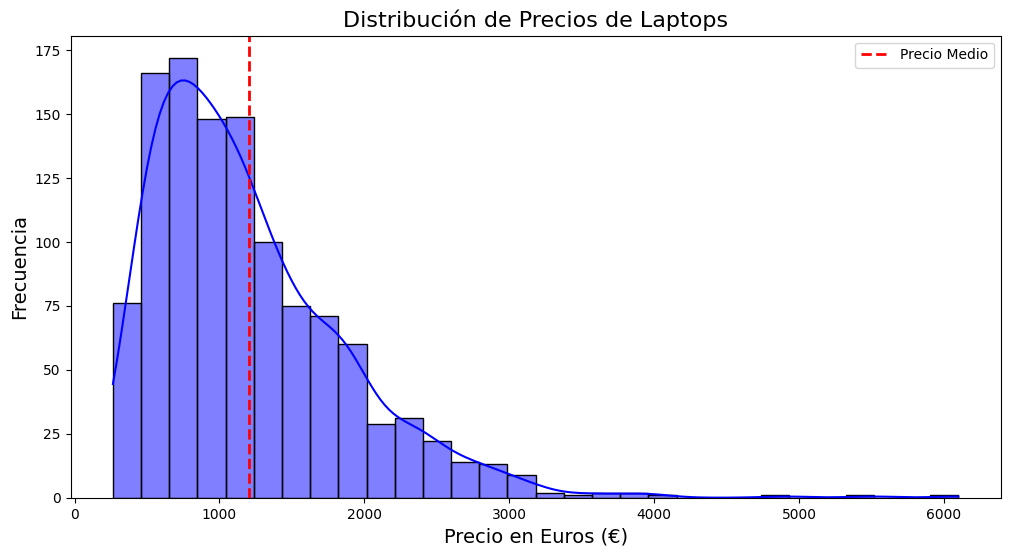

Muestra la distribución de precios de las laptops con una curva de densidad.


In [504]:
#DETERMINANDO LA DISTRIBUCIÓN DE LOS PRECIOS

plt.figure(figsize=(12, 6))
sns.histplot(df['Price_euros'], bins=30, kde=True, color='blue')
plt.title('Distribución de Precios de Laptops', fontsize=16)
plt.xlabel('Precio en Euros (€)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.axvline(df['Price_euros'].mean(), color='red', linestyle='dashed', linewidth=2, label='Precio Medio')
plt.legend()
plt.show()
print('Muestra la distribución de precios de las laptops con una curva de densidad.')

*Podemos observar que no es una distribución normal*

In [505]:
#Determinando valor de Skweness
df['Price_euros'].skew()

np.float64(1.5984726947148369)

*skew positivo de 1.598 indica una distribución sesgada a la derecha, lo que es importante tener en cuenta al interpretar y analizar los datos.*

In [506]:
#Determinando valor de Kurtosis
df['Price_euros'].kurt()

np.float64(4.9145602034098435)

 *kurtosis de 4.915 indica que la distribución es leptocúrtica, con colas más pesadas y una mayor propensión a la presencia de valores extremos. Esto es importante a tener en cuenta al analizar la distribución de los datos.*

**Graficando relación Precio vs. Pulgadas**

In [507]:
Graf_1 = pd.concat([df['Price_euros'],Pulg],axis=1)
Graf_1.head(5)

,Price_euros,Inches
0,575.0,15.6
1,400.0,15.6
2,1495.0,14.0
3,770.0,14.0
4,393.9,15.6


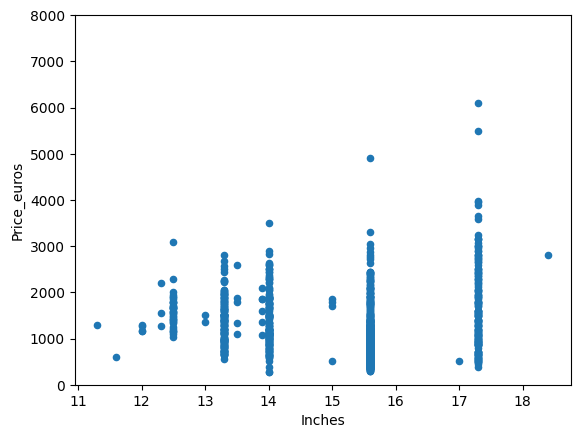

In [508]:
Graf_1['Inches'] = Graf_1['Inches'].astype(float)
Graf_1['Price_euros'] = Graf_2['Price_euros'].astype(float)

Graf_1.plot.scatter(x='Inches', y='Price_euros', ylim=(0, 8000));

**Graficando relación Precio vs. Ram**

In [509]:
Graf_2 = pd.concat([df['Price_euros'],Ram],axis=1)
Graf_2.head(5)

,Price_euros,Ram
0,575.0,8GB
1,400.0,4GB
2,1495.0,16GB
3,770.0,8GB
4,393.9,4GB


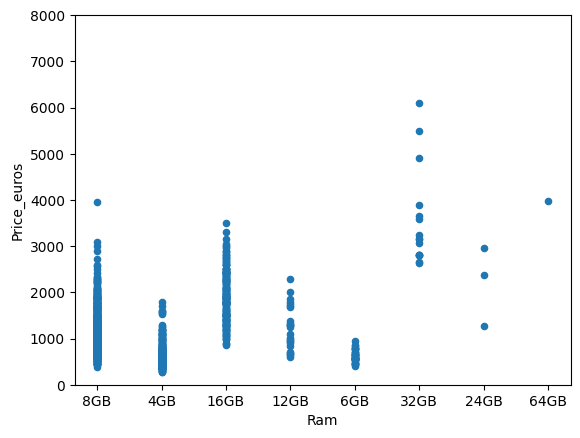

In [521]:

Graf_2['Ram'] = Graf_2['Ram'].astype(str)
Graf_2['Price_euros'] = Graf_2['Price_euros'].astype(float)
Graf_2.plot.scatter(x='Ram', y='Price_euros', ylim=(0, 8000));

**Graficando relación Precio vs. Cpu Rate**

In [471]:
Graf_3 = pd.concat([df['Price_euros'],CpuR],axis=1)
Graf_3.head(5)

,Price_euros,Cpu Rate
0,575.0,2.5
1,400.0,NaN
2,1495.0,1.8
3,770.0,1.6
4,393.9,2.5


(np.float64(-0.5), np.float64(22.5), np.float64(0.0), np.float64(8000.0))

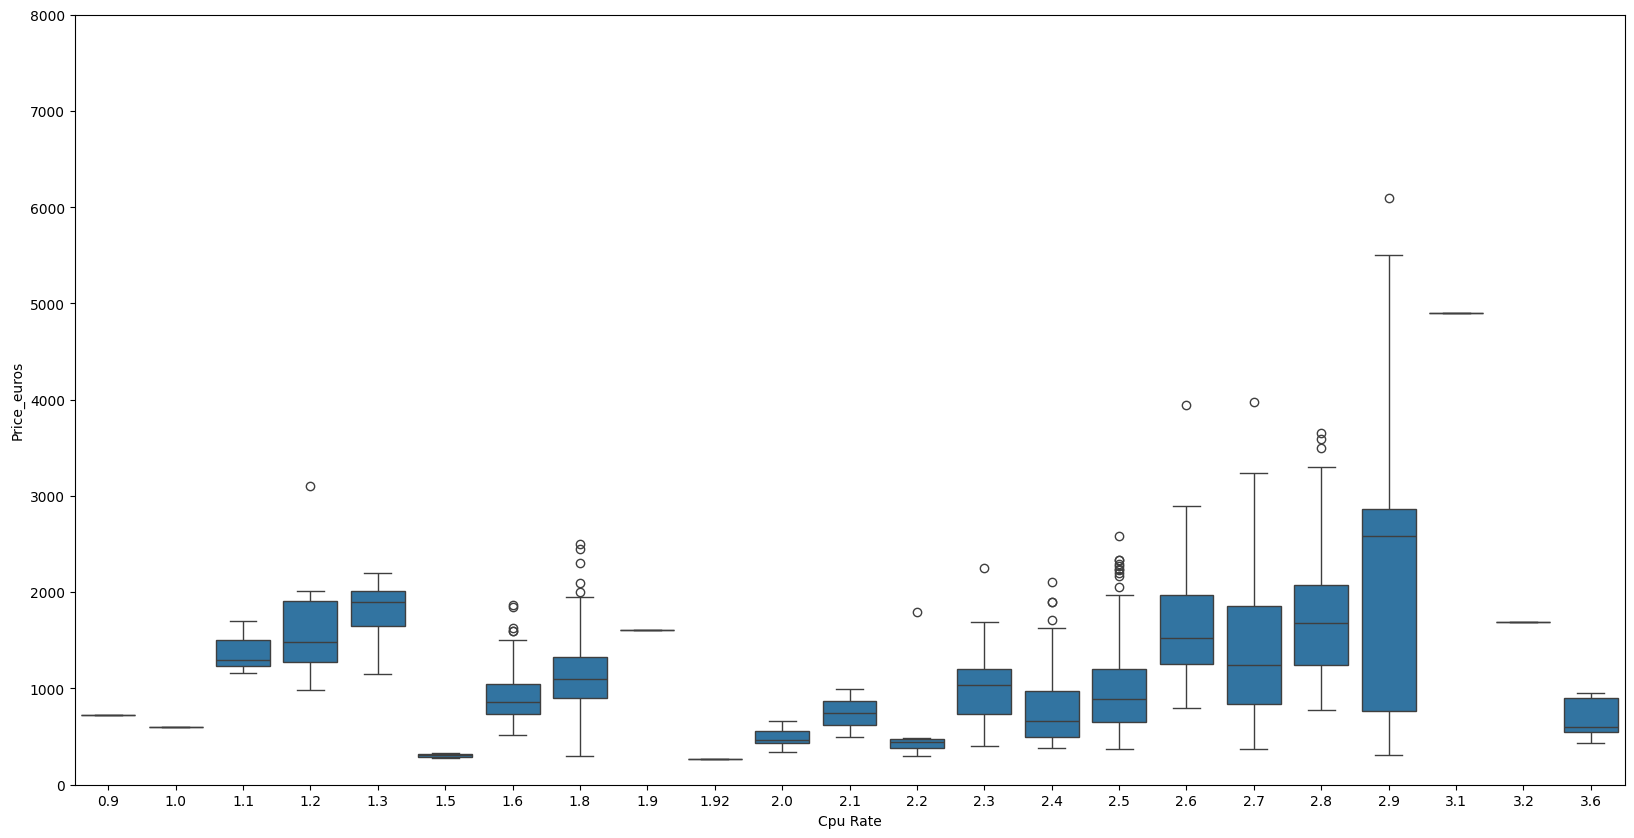

In [472]:
f, ax = plt.subplots(figsize=(20,10))
fig = sns.boxplot(x=CpuR , y=df['Price_euros'] , data=Graf_3)
fig.axis(ymin=0 , ymax=8000)

**Graficando relación Precio vs. SSD**

In [473]:
Graf_4 = pd.concat([df['Price_euros'],SSD],axis=1)
Graf_4.head(5)

,Price_euros,SSD
0,575.0,256
1,400.0,0
2,1495.0,512
3,770.0,256
4,393.9,0


(np.float64(-0.5), np.float64(8.5), np.float64(0.0), np.float64(8000.0))

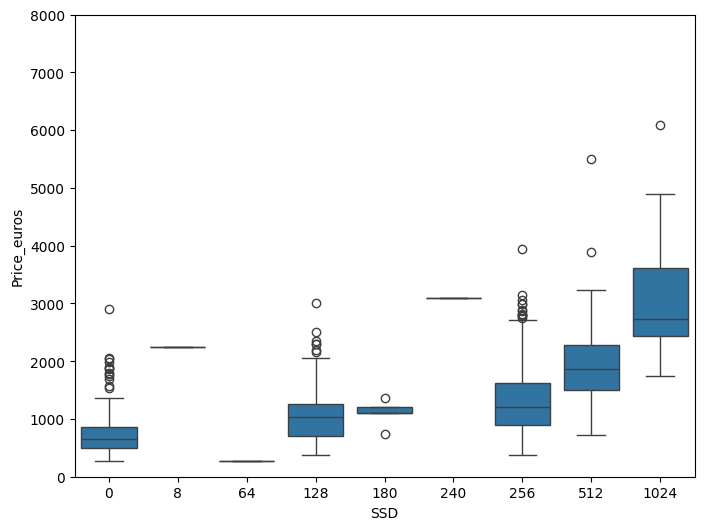

In [474]:
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=SSD , y=df['Price_euros'] , data=Graf_4)
fig.axis(ymin=0 , ymax=8000)

**Graficando relación Precio vs. HDD**

In [475]:
Graf_5 = pd.concat([df['Price_euros'],HDD],axis=1)
Graf_5.head(5)

,Price_euros,HDD
0,575.0,0
1,400.0,500
2,1495.0,0
3,770.0,0
4,393.9,500


(np.float64(-0.5), np.float64(6.5), np.float64(0.0), np.float64(8000.0))

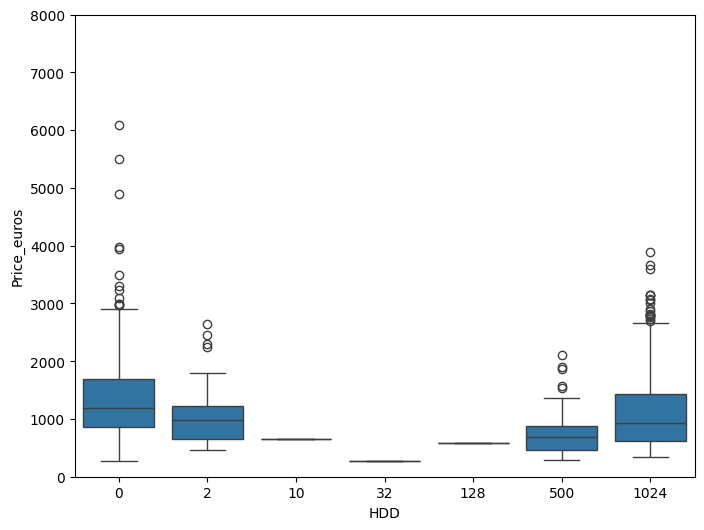

In [476]:
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=HDD , y=df['Price_euros'] , data=Graf_5)
fig.axis(ymin=0 , ymax=8000)

**Generando un mapa de calor para evaluar la relacion que guarda el precio con el resto de variables cuantitativas**

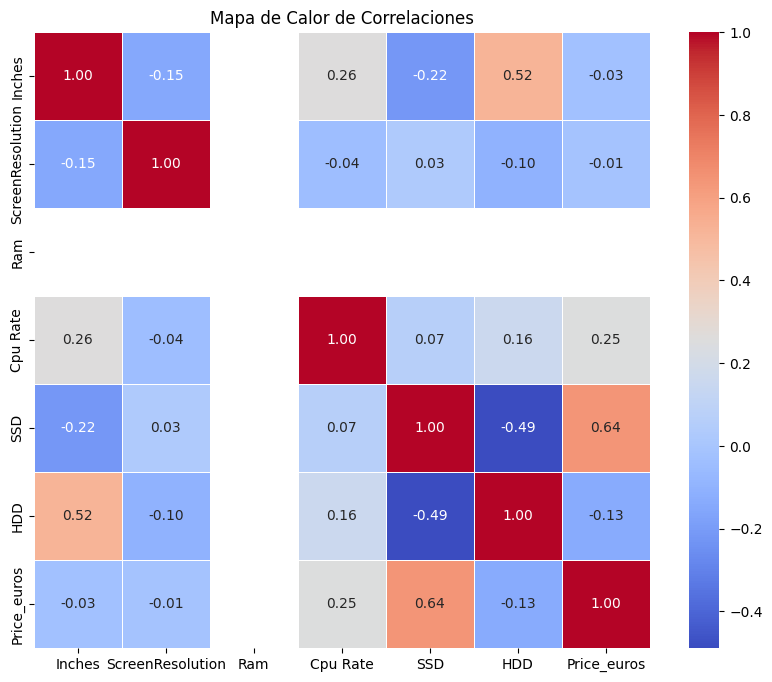

In [516]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Configuración del mapa de calor
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura si es necesario
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)

# Títulos y etiquetas
plt.title('Mapa de Calor de Correlaciones')
plt.show()

****Por lo observado anteriormente, en cuanto a los Atributos cuantitativos, no se encuentra una relacion marcada con respecto del precio. La capacidad de la SSD es la que mayor relación Guarda con el precio llegando a los 0.64, seguido por muy lejos por la capacidad de refresco del CPU que cuenta con el 0.25.****

In [518]:
print(df.dtypes)

Inches              float64
ScreenResolution    float64
Ram                 float64
Cpu Rate            float64
SSD                   int64
HDD                   int64
Price_euros         float64
dtype: object
